# 1. Introduction

## 1.1 Datasets

### In this file we'll model with our three different datasets that we prepared in the first file:

#### 1. The kitchen sink (all data, all levels)
#### 2. Hand engineered features (reduced levels)
#### 3. Hand engineered features with features hand selected

## 1.2 Modelling approaches

### We'll model using two approaches: a penalised logistic regression and a tree-based method. Both of these methods have their advantages and disadvantages. 

### The logistic regression gives coefficients that determine exactly how important each feature is, but is incapable of automatically finding interactions. Tree based methods are good at finding interactions but the importance measure is based upon how many times the variable was "split" on and so this measure of importance is less exact than in the GLM

## 1.3 Data splitting

### Training will be conducted by splitting the data into two partitions: train (80%) and test (20%).
### If we had more data we'd use a train:60%, val:20%, test:20% split, using the test split to evaluate model design before finally testing on test. 

### Instead of this, we'll use 5 fold cross validation to perform model design before testing right at the end

### Cross validation will also give us a distribution of model performance rather than just a point estimate

## 1.4 Model evaluation

### We'll evaluate our models' performance using a confusion matrix and ROC curve. 

# 2. Libraries

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.inspection import permutation_importance

# 3. Load the data

### 3.1 Kitchen sink 

In [2]:
hd_data_ks = pd.read_csv('../data/cleaned/kitchen_sink.csv')

In [3]:
hd_data_ks.shape

(284, 26)

### 3.2 Hand tuned

In [4]:
hd_data_ht = pd.read_csv('../data/cleaned/hand_tuned.csv')

In [5]:
hd_data_ht.shape

(284, 21)

### 3.3 Hand tuned,feature selected

In [6]:
hd_data_ht_cd = pd.read_csv('../data/cleaned/hand_tuned_feature_selected.csv')

In [7]:
hd_data_ht_cd.shape

(284, 17)

# 4. Split the data into an 80/20 split

In [8]:
ht_cd_shuff = hd_data_ht_cd.sample(frac=1)
ht_cd_shuff_train, ht_cd_shuff_test = np.split(ht_cd_shuff, [int(.8*len(ht_cd_shuff))])
ht_cd_shuff_train.shape

(227, 17)

In [9]:
ht_cd_shuff_test.shape

(57, 17)

In [10]:
ht_shuff = hd_data_ht.sample(frac=1)
ht_shuff_train, ht_shuff_test = np.split(ht_shuff, [int(.8*len(ht_shuff))])
ht_shuff_train.shape

(227, 21)

In [11]:
ks_shuff = hd_data_ks.sample(frac=1)
ks_shuff_train, ks_shuff_test = np.split(ks_shuff, [int(.8*len(ks_shuff))])
ks_shuff_train.shape

(227, 26)

# 5. Shallow RF

### 5.1 Hand tuned, feature selected dataset

In [114]:
rf_ht_cd = RandomForestClassifier(max_depth=5, random_state=0)

In [40]:
ht_cd_shuff_train["num"] = ht_cd_shuff_train["num"].astype('bool')

In [41]:
np_ht_cd_shuff_train = ht_cd_shuff_train.to_numpy()
np_ht_cd_shuff_test =  ht_cd_shuff_test.to_numpy()

In [42]:
x = np_ht_cd_shuff_train[:,0:16]
y = np_ht_cd_shuff_train[:,16]
y=y.astype('bool')

In [43]:
x_ = np_ht_cd_shuff_test[:,0:16]
y_ = np_ht_cd_shuff_test[:,16]
y_=y_.astype('bool')

### 5.1.1 Cross validated CV to get performance distribution

In [44]:
scores_ht_cd = cross_val_score(rf_ht_cd, x, y, cv=5)

In [45]:
scores_ht_cd

array([0.86956522, 0.73913043, 0.73333333, 0.91111111, 0.88888889])

In [46]:
scores_ht_cd.mean()

0.8284057971014492

### 5.1.2 Re-run to get feature importance on the whole dataset

In [48]:
rf_ht_cd.fit(x,y)

RandomForestClassifier(max_depth=5, random_state=0)

<ipython-input-68-a452e640b226>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(features_trans,fontsize=20)


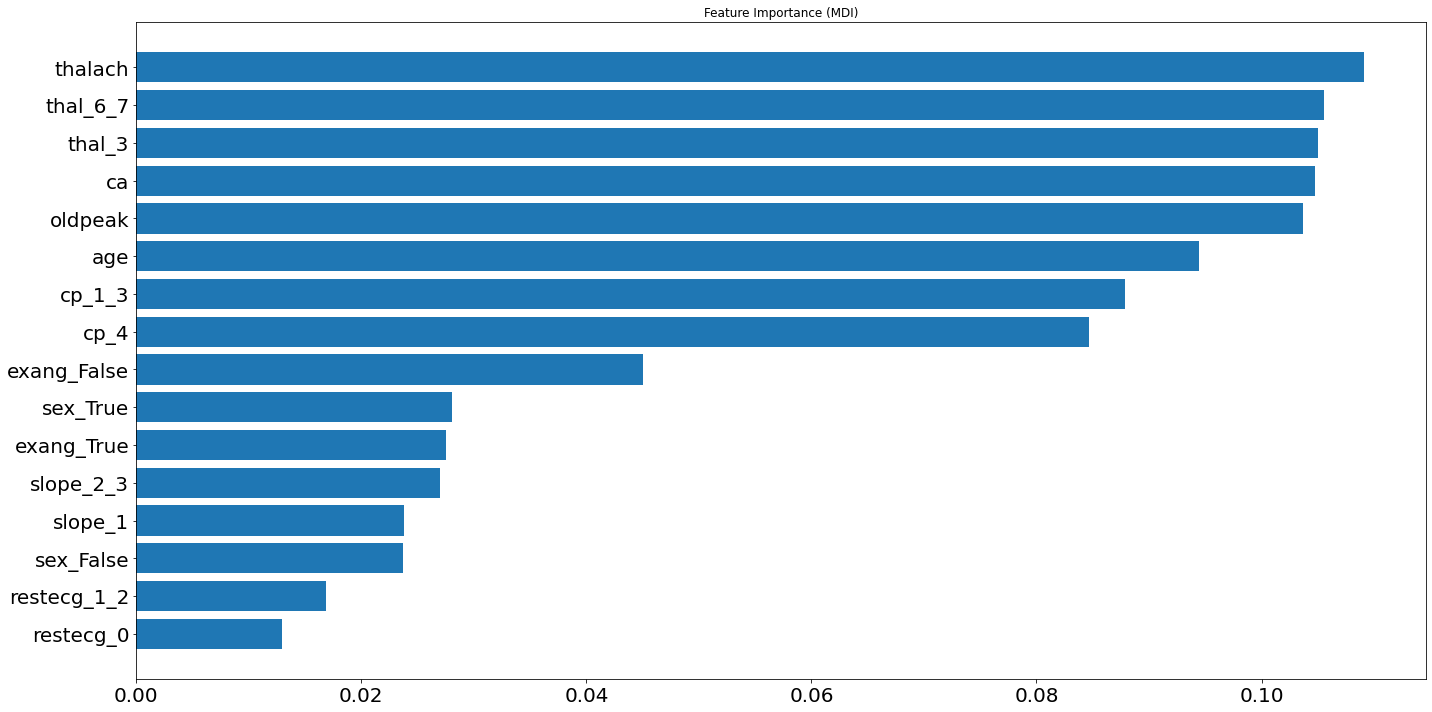

In [68]:
features = ht_cd_shuff_train.columns.tolist()[:-1]

tree_feature_importances = (rf_ht_cd.feature_importances_)

sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(features))
fig, ax = plt.subplots(figsize=(20,10))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
features_trans = [features[i] for i in sorted_idx]
ax.set_yticklabels(features_trans,fontsize=20)
ax.set_yticks(y_ticks)
ax.set_title("Feature Importance (MDI)")
ax.tick_params(axis='x', labelsize= 20)
fig.tight_layout()
plt.show()

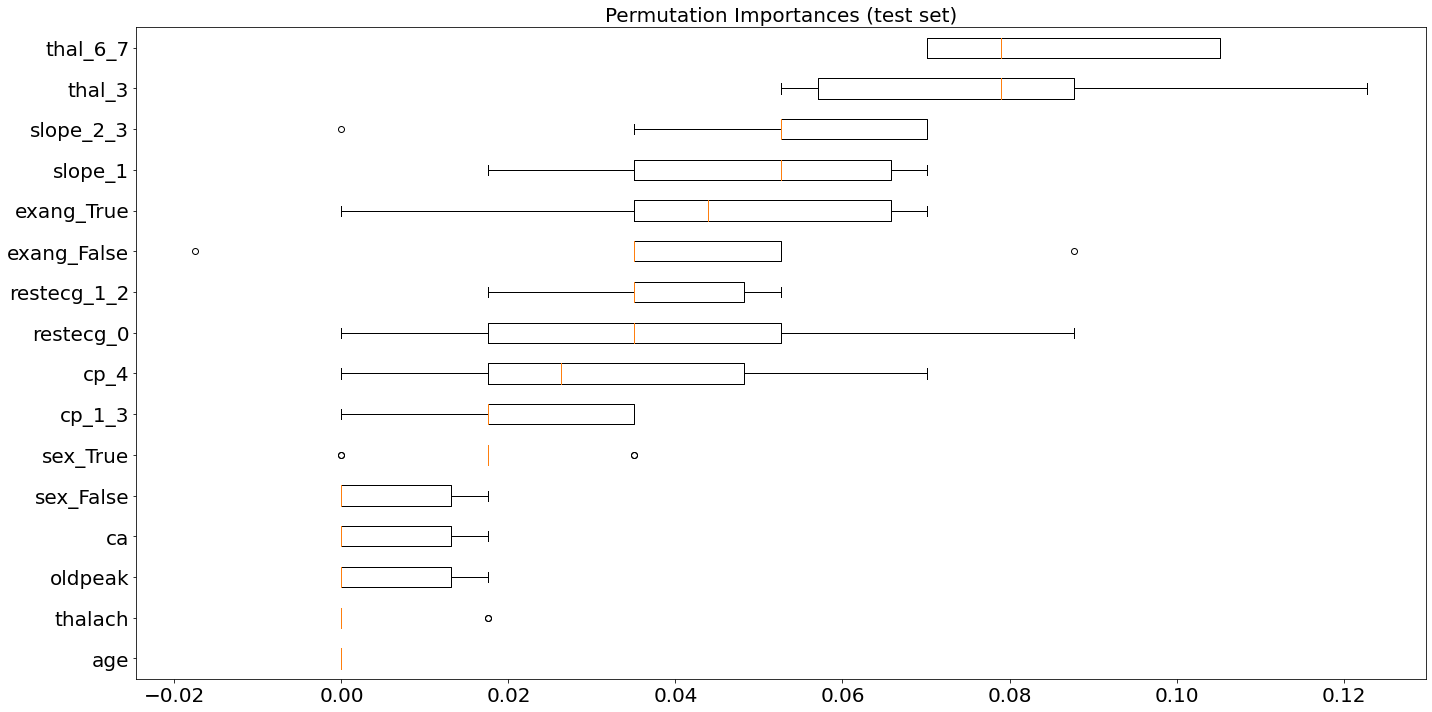

In [83]:
result = permutation_importance(rf_ht_cd, x_, y_, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

features = ht_cd_shuff_train.columns.tolist()[:-1]

fig, ax = plt.subplots(figsize=(20,10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=features)
ax.set_title("Permutation Importances (test set)",fontsize=20)
ax.tick_params(axis='x', labelsize= 20)
ax.tick_params(axis='y', labelsize= 20)
fig.tight_layout()
plt.show()

### 5.1.4 Performance on held out test set

In [85]:
sklearn.metrics.roc_auc_score(y_, rf_ht_cd.predict(x_))

0.9482758620689655

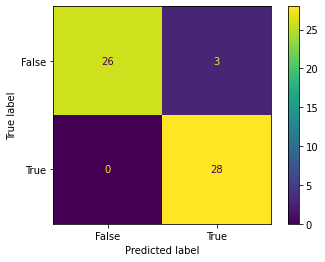

In [87]:
plot_confusion_matrix(rf_ht_cd, x_, y_) 

### 5.2 Hand tuned dataset (no feature selection)

### 5.2.1 CV train

In [88]:
ht_shuff_train["num"] = ht_shuff_train["num"].astype('bool')

In [89]:
np_ht_shuff_train = ht_shuff_train.to_numpy()
np_ht_shuff_test =  ht_shuff_test.to_numpy()

In [90]:
x = np_ht_shuff_train[:,0:20]
y = np_ht_shuff_train[:,20]
y=y.astype('bool')

In [91]:
x_ = np_ht_shuff_test[:,0:20]
y_ = np_ht_shuff_test[:,20]
y_=y_.astype('bool')

In [92]:
rf_ht = RandomForestClassifier(max_depth=5, random_state=0)

In [93]:
scores_ht = cross_val_score(rf_ht, x, y, cv=5)

In [94]:
scores_ht

array([0.86956522, 0.91304348, 0.86666667, 0.77777778, 0.82222222])

In [95]:
scores_ht.mean()

0.8498550724637681

### 5.2.2 Get feature importances

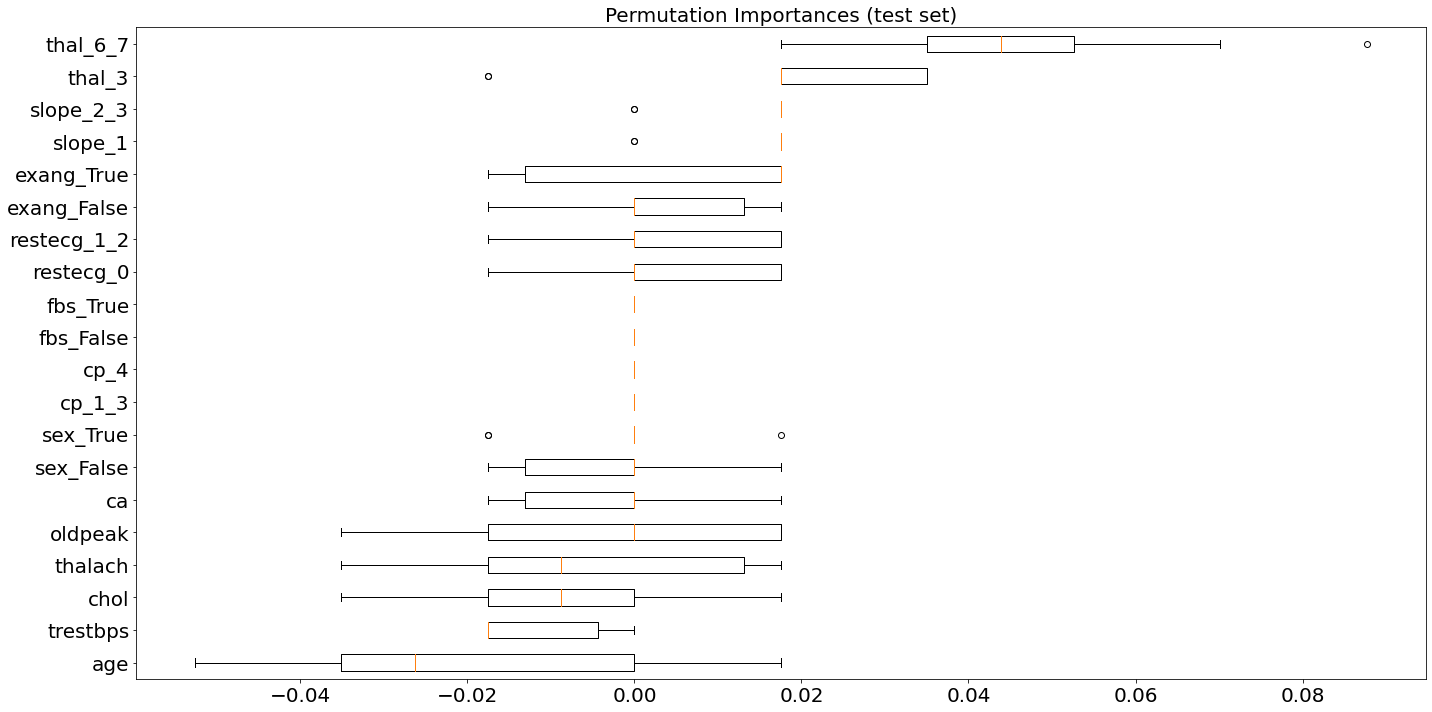

In [99]:
rf_ht.fit(x,y)

result = permutation_importance(rf_ht, x_, y_, n_repeats=10, random_state=0, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

features = ht_shuff_train.columns.tolist()[:-1]

fig, ax = plt.subplots(figsize=(20,10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=features)
ax.set_title("Permutation Importances (test set)",fontsize=20)
ax.tick_params(axis='x', labelsize= 20)
ax.tick_params(axis='y', labelsize= 20)
fig.tight_layout()
plt.show()

### Hold out performance

0.7803030303030304


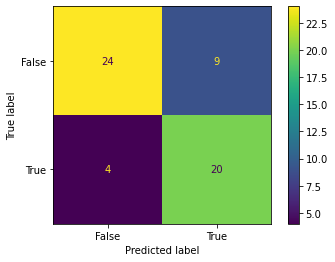

In [101]:
print(sklearn.metrics.roc_auc_score(y_, rf_ht.predict(x_)))
plot_confusion_matrix(rf_ht, x_, y_) 

### 5.3 Kitchen sink dataset

In [102]:
ks_shuff_train["num"] = ks_shuff_train["num"].astype('bool')

In [103]:
np_ks_shuff_train = ks_shuff_train.to_numpy()
np_ks_shuff_test =  ks_shuff_test.to_numpy()

In [104]:
x = np_ks_shuff_train[:,0:25]
y = np_ks_shuff_train[:,25]
y=y.astype('bool')

In [105]:
x_ = np_ks_shuff_test[:,0:25]
y_ = np_ks_shuff_test[:,25]
y_=y_.astype('bool')

In [106]:
rf_ks = RandomForestClassifier(max_depth=5, random_state=0)

In [107]:
scores_ks = cross_val_score(rf_ks, x, y, cv=5)

In [108]:
scores_ks

array([0.82608696, 0.84782609, 0.84444444, 0.82222222, 0.8       ])

In [109]:
scores_ks.mean()

0.8281159420289855

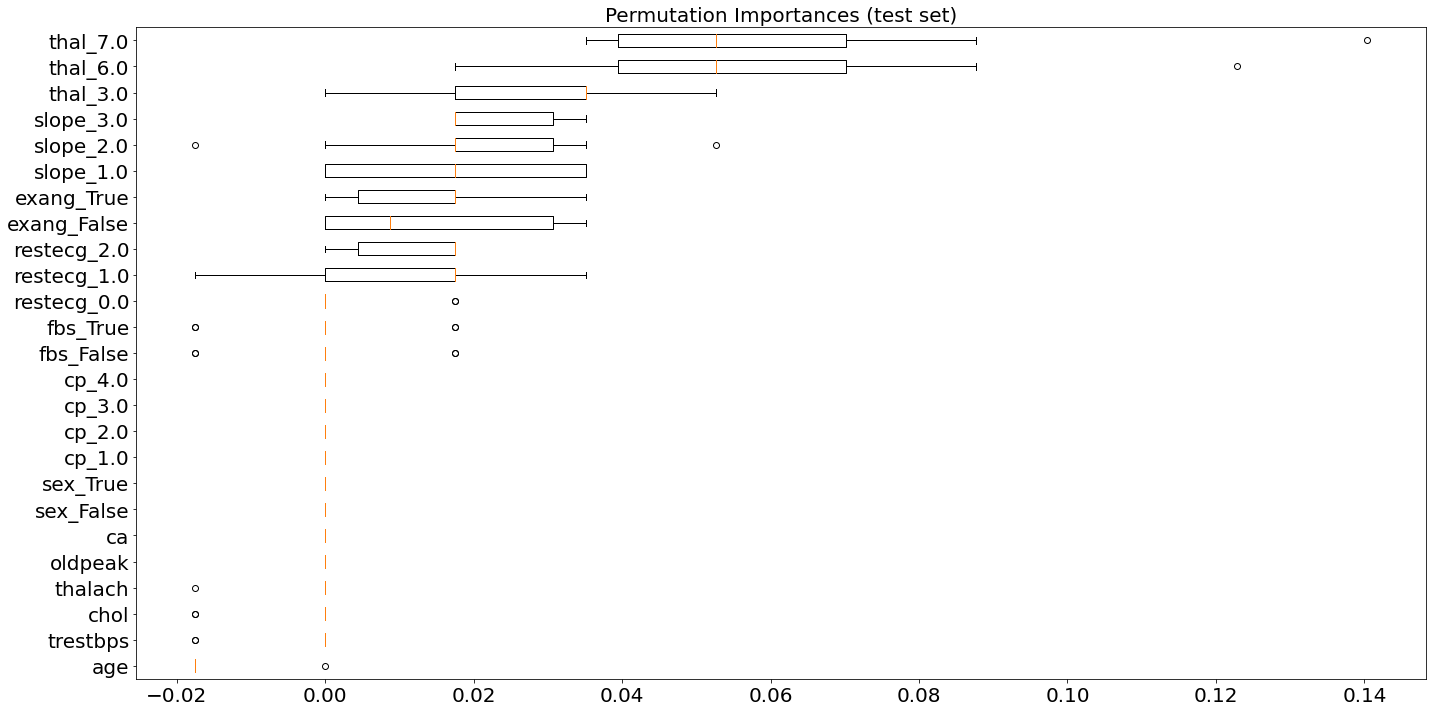

In [111]:
rf_ks.fit(x,y)

result = permutation_importance(rf_ks, x_, y_, n_repeats=10, random_state=0, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

features = ks_shuff_train.columns.tolist()[:-1]

fig, ax = plt.subplots(figsize=(20,10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=features)
ax.set_title("Permutation Importances (test set)",fontsize=20)
ax.tick_params(axis='x', labelsize= 20)
ax.tick_params(axis='y', labelsize= 20)
fig.tight_layout()
plt.show()

### Hold out performance

0.7906403940886699


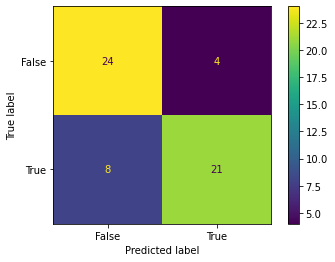

In [112]:
print(sklearn.metrics.roc_auc_score(y_, rf_ks.predict(x_)))
plot_confusion_matrix(rf_ks, x_, y_) 